In [1]:
import os
import numpy as np
import argparse
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

from utl2 import dataset, ToTensor
from cnn_mlp import CNN_MLP
from cnn_lstm import CNN_LSTM
from resnet18 import Resnet18_MLP
from cnn_logical_v1 import CNN_Logical

In [2]:
class args():
    model='CNN_Logical'
    epochs=200
    batch_size=32
    seed=12345
    dataset = 'iRaven'
    device = 2
    load_workers = 16
    resume = False
    path = "/common/users/pv217/pritish_data"
    save = "/common/users/pv217/model_checkpoints/not_all_augs_10_aug/"
    img_size = 80
    lr = 1e-4
    beta1 = 0.9
    beta2 = 0.999
    epsilon = 1e-8
    meta_alpha = 0.0
    meta_beta = 0.0
    cuda = torch.cuda.is_available()    

In [3]:
args.cuda = torch.cuda.is_available()
torch.cuda.set_device(args.device)
if args.cuda:
    torch.cuda.manual_seed(args.seed)

In [4]:
data_path = "/common/users/pv217/pritish_data"

In [5]:
train = dataset(data_path, "train", args.img_size, transform=transforms.Compose([ToTensor()]),shuffle=True,
                rotate=False,vertical_flip=True, vertical_roll = False,
                horizontal_flip = True, horizontal_roll= False, max_rotate_angle = 180
               )
valid = dataset(data_path, "val", args.img_size, transform=transforms.Compose([ToTensor()]))
test = dataset(data_path, "test", args.img_size, transform=transforms.Compose([ToTensor()]))

In [6]:
trainloader = DataLoader(train, batch_size=args.batch_size, shuffle=True, num_workers=16)
validloader = DataLoader(valid, batch_size=args.batch_size, shuffle=False, num_workers=16)
testloader = DataLoader(test, batch_size=args.batch_size, shuffle=False, num_workers=16)

In [7]:
train.__getitem__(1)[2].shape

torch.Size([9])

In [8]:
train.__getitem__(1)[2].sum()

tensor(9.)

In [9]:
if args.model == "CNN_MLP":
    model = CNN_MLP(args)
elif args.model == "CNN_LSTM":
    model = CNN_LSTM(args)
elif args.model == "Resnet18_MLP":
    model = Resnet18_MLP(args)
elif args.model == "CNN_Logical":
    model = CNN_Logical(args)

In [10]:
if args.resume:
    model.load_model(args.save, 0)
    print('Loaded model')
if args.cuda:
    model = model.cuda()

In [11]:
def train(epoch):
    model.train()
    train_loss = 0
    accuracy = 0

    loss_all = 0.0
    acc_all = 0.0
    counter = 0
    for batch_idx, (image, target, meta_target) in enumerate(trainloader):
        counter += 1
        if args.cuda:
            image = image.cuda()
            target = target.cuda()
            meta_target = meta_target.cuda()
#             meta_structure = meta_structure.cuda()
#             embedding = embedding.cuda()
#             indicator = indicator.cuda()
        loss, acc = model.train_(image, target, meta_target)
        #print('Train: Epoch:{}, Batch:{}, Loss:{:.6f}, Acc:{:.4f}.'.format(epoch, batch_idx, loss, acc))
        loss_all += loss
        acc_all += acc
    print(epoch)
    if counter > 0:
        print("Avg Training Loss: {:.6f}".format(loss_all/float(counter)))
    return loss_all/float(counter), acc_all/float(counter)


In [12]:
def validate(epoch):
    model.eval()
    val_loss = 0
    accuracy = 0

    loss_all = 0.0
    acc_all = 0.0
    counter = 0
    for batch_idx, (image, target, meta_target) in enumerate(validloader):
        counter += 1
        if args.cuda:
            image = image.cuda()
            target = target.cuda()
            meta_target = meta_target.cuda()
#             meta_structure = meta_structure.cuda()
#             embedding = embedding.cuda()
#             indicator = indicator.cuda()
        loss, acc = model.validate_(image, target, meta_target)
        # print('Validate: Epoch:{}, Batch:{}, Loss:{:.6f}, Acc:{:.4f}.'.format(epoch, batch_idx, loss, acc)) 
        loss_all += loss
        acc_all += acc
    if counter > 0:
        print("Total Validation Loss: {:.6f}, Acc: {:.4f}".format(loss_all/float(counter), acc_all/float(counter)))
    return loss_all/float(counter), acc_all/float(counter)

In [13]:
def test(epoch):
    model.eval()
    accuracy = 0

    acc_all = 0.0
    counter = 0
    for batch_idx, (image, target, meta_target) in enumerate(testloader):
        counter += 1
        if args.cuda:
            image = image.cuda()
            target = target.cuda()
            meta_target = meta_target.cuda()
#             meta_structure = meta_structure.cuda()
#             embedding = embedding.cuda()
#             indicator = indicator.cuda()
        acc = model.test_(image, target, meta_target)
        # print('Test: Epoch:{}, Batch:{}, Acc:{:.4f}.'.format(epoch, batch_idx, acc))  
        acc_all += acc
    if counter > 0:
        print("Total Testing Acc: {:.4f}".format(acc_all / float(counter)))
    return acc_all/float(counter)

In [ ]:
epoch_lst = []
train_loss_lst = []
train_acc_lst = []
val_loss_lst = []
val_acc_lst = []
test_acc_lst = []

for epoch in range(0, args.epochs):
    train_loss, train_acc = train(epoch)
    val_loss, val_acc = validate(epoch)
    test_acc = test(epoch)
    epoch_lst.append(epoch)
    train_loss_lst.append(train_loss)
    train_acc_lst.append(train_acc)
    val_loss_lst.append(val_loss)
    val_acc_lst.append(val_acc)
    test_acc_lst.append(test_acc)
    model.save_model(args.save, epoch, val_acc, val_loss)
    
    

0
Avg Training Loss: 2.483565
Total Validation Loss: 2.229651, Acc: 13.5845
Total Testing Acc: 12.8710
1
Avg Training Loss: 2.204573
Total Validation Loss: 2.137079, Acc: 15.4966
Total Testing Acc: 15.0756
2
Avg Training Loss: 2.144593
Total Validation Loss: 2.102989, Acc: 16.2243
Total Testing Acc: 15.8176
3
Avg Training Loss: 2.105774
Total Validation Loss: 2.073417, Acc: 17.7369
Total Testing Acc: 17.6727
4
Avg Training Loss: 2.062119
Total Validation Loss: 2.003793, Acc: 19.3850
Total Testing Acc: 19.3422
5
Avg Training Loss: 2.021295
Total Validation Loss: 1.977103, Acc: 19.9272
Total Testing Acc: 20.0628
6
Avg Training Loss: 1.989734
Total Validation Loss: 1.949113, Acc: 20.2911
Total Testing Acc: 20.6692
7
Avg Training Loss: 1.965781
Total Validation Loss: 1.924302, Acc: 20.7691
Total Testing Acc: 20.9974
8
Avg Training Loss: 1.945775
Total Validation Loss: 1.909757, Acc: 21.8179
Total Testing Acc: 21.5896
9
Avg Training Loss: 1.925374
Total Validation Loss: 1.893782, Acc: 21.95

In [42]:
import pandas as pd
import seaborn as sns

In [43]:
training_stats = pd.DataFrame({'epoch':epoch_lst,
 'training_loss':train_loss_lst,
 'training_accuracy':train_acc_lst,
 'validation_loss':val_loss_lst,
 'validation_accuracy':val_acc_lst,
 'test_accuracy':test_acc_lst
})

In [44]:
training_stats = training_stats.set_index('epoch')

In [45]:
sns.set(rc = {'figure.figsize':(15,8)})

<AxesSubplot:xlabel='epoch'>

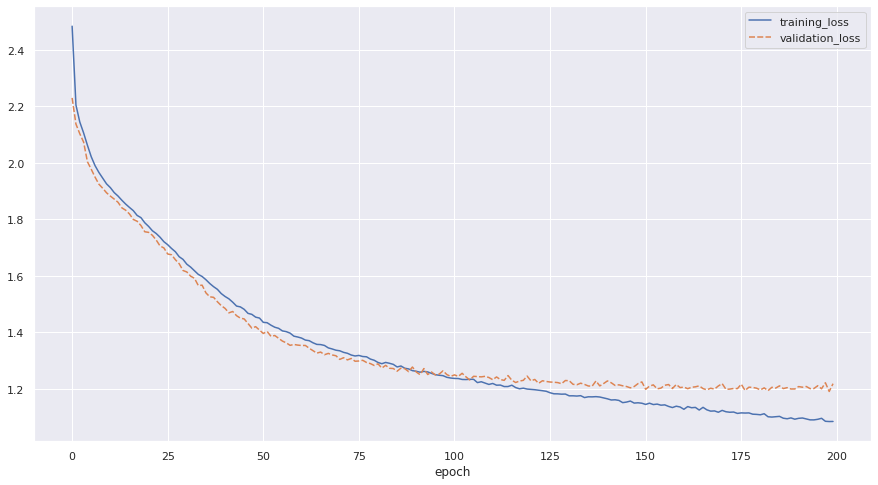

In [46]:
sns.lineplot(data=training_stats[['training_loss','validation_loss']])

<AxesSubplot:xlabel='epoch'>

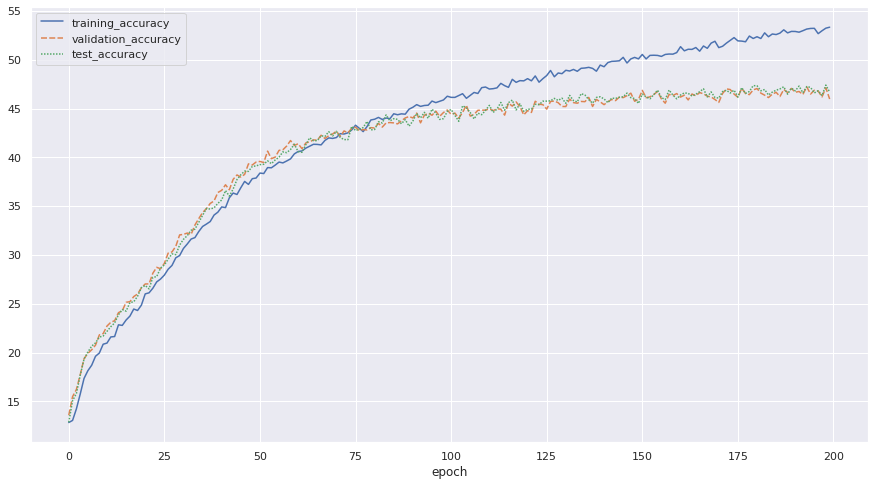

In [47]:
sns.lineplot(data=training_stats[['training_accuracy','validation_accuracy','test_accuracy']])

#### Checking Model performance on each configuration  

In [48]:
def validate():
    model.eval()
    val_loss = 0
    accuracy = 0
    epoch = 1
    loss_all = 0.0
    acc_all = 0.0
    counter = 0
    for batch_idx, (image, target, meta_target) in enumerate(validloader):
        counter += 1
#         print(counter)
        if args.cuda:
            image = image.cuda()
            target = target.cuda()
            meta_target = meta_target.cuda()
#             meta_structure = meta_structure.cuda()
        loss, acc = model.validate_(image, target, meta_target)
#         print('Validate: Epoch:{}, Batch:{}, Loss:{:.6f}, Acc:{:.4f}.'.format(epoch, batch_idx, loss, acc)) 
        loss_all += loss
        acc_all += acc
#         print(counter)
    if counter >0:
        print("Total Validation Loss: {:.6f}, Acc: {:.4f}".format(loss_all/float(counter), acc_all/float(counter)))
    return  acc_all/float(counter)

def test():
    model.eval()
    accuracy = 0
    epoch = 1
    acc_all = 0.0
    counter = 0
    for batch_idx, (image, target, meta_target) in enumerate(testloader):
        counter += 1
        if args.cuda:
            image = image.cuda()
            target = target.cuda()
            meta_target = meta_target.cuda()
#             meta_structure = meta_structure.cuda()
#             embedding = embedding.cuda()
#             indicator = indicator.cuda()
        acc = model.test_(image, target, meta_target)
        # print('Test: Epoch:{}, Batch:{}, Acc:{:.4f}.'.format(epoch, batch_idx, acc))  
        acc_all += acc
    if counter > 0:
        print("Total Testing Acc: {:.4f}".format(acc_all / float(counter)))
    return acc_all/float(counter)

In [49]:
config_lst = []
config_val_acc_list = []
config_test_acc_list = []
for i in ['/center_single/','/distribute_four/','/distribute_nine/',
          '/in_center_single_out_center_single/','/in_distribute_four_out_center_single/', 
          '/left_center_single_right_center_single/','/up_center_single_down_center_single/']:
    valid_dt = dataset(data_path, "val", args.img_size, transform=transforms.Compose([ToTensor()]))
    test_dt = dataset(data_path, "test", args.img_size, transform=transforms.Compose([ToTensor()]))
    valid_dt.file_names = [x for x in valid_dt.file_names if i in x]
    test_dt.file_names = [x for x in test_dt.file_names if i in x]
    validloader = DataLoader(valid_dt, batch_size=args.batch_size, shuffle=False, num_workers=16)
    testloader = DataLoader(test_dt, batch_size=args.batch_size, shuffle=False, num_workers=16)
    config_lst.append(i[1:-1])
    config_val_acc_list.append(validate())
    config_test_acc_list.append(test())
    
    

Total Validation Loss: 0.755927, Acc: 70.8829
Total Testing Acc: 68.1052
Total Validation Loss: 1.240870, Acc: 44.9405
Total Testing Acc: 45.2877
Total Validation Loss: 1.437018, Acc: 38.1944
Total Testing Acc: 40.5258
Total Validation Loss: 1.104257, Acc: 45.7341
Total Testing Acc: 45.8333
Total Validation Loss: 1.183910, Acc: 42.3115
Total Testing Acc: 44.1468
Total Validation Loss: 1.382347, Acc: 41.6171
Total Testing Acc: 43.3036
Total Validation Loss: 1.420869, Acc: 38.4425
Total Testing Acc: 39.2361


In [50]:
pd.DataFrame({'configuration':config_lst,'validation_accuracy':config_val_acc_list, 'test_accuracy':config_test_acc_list})

,configuration,validation_accuracy,test_accuracy
0,center_single,70.882937,68.105159
1,distribute_four,44.940476,45.287698
2,distribute_nine,38.194444,40.525794
3,in_center_single_out_center_single,45.734127,45.833333
4,in_distribute_four_out_center_single,42.311508,44.146825
5,left_center_single_right_center_single,41.617063,43.303571
6,up_center_single_down_center_single,38.442460,39.236111


<AxesSubplot:xlabel='configuration', ylabel='test_accuracy'>

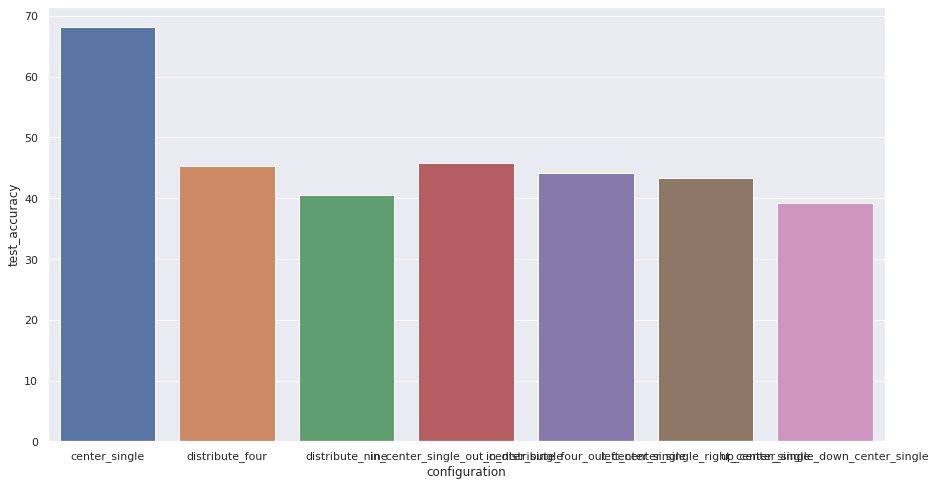

In [51]:
sns.barplot(x="configuration", y="test_accuracy", data=pd.DataFrame({'configuration':config_lst,'validation_accuracy':config_val_acc_list, 'test_accuracy':config_test_acc_list}))

In [52]:
# sns.s pd.DataFrame({'configuration':config_lst,'validation_accuracy':config_val_acc_list, 'test_accuracy':config_test_acc_list}).set_index('configuration')

In [55]:
for i in ['/center_single/','/distribute_four/','/in_distribute_four_out_center_single/', '/left_center_single_right_center_single/']:
    train_dt = dataset(data_path, "train", args.img_size, transform=transforms.Compose([ToTensor()]))
    valid_dt = dataset(data_path, "val", args.img_size, transform=transforms.Compose([ToTensor()]))
    test_dt = dataset(data_path, "test", args.img_size, transform=transforms.Compose([ToTensor()]))
    train_dt.file_names = [x for x in train_dt.file_names if i in x]
    valid_dt.file_names = [x for x in valid_dt.file_names if i in x]
    test_dt.file_names = [x for x in test_dt.file_names if i in x]
    print(i,len(set(train_dt.file_names)),len(set(valid_dt.file_names)),len(set(test_dt.file_names)))


/center_single/ 6000 2000 2000
/distribute_four/ 6000 2000 2000
/in_distribute_four_out_center_single/ 6000 2000 2000
/left_center_single_right_center_single/ 6000 2000 2000


In [56]:
training_stats.tail(10)

,training_loss,training_accuracy,validation_loss,validation_accuracy,test_accuracy
epoch,,,,,
190,1.095222,52.894136,1.207632,46.668094,46.810788
191,1.096346,52.820354,1.205366,46.746575,47.303082
192,1.092876,52.972677,1.207919,46.439783,46.611016
193,1.089773,53.139280,1.200480,47.231735,47.246005
194,1.089669,53.203542,1.200680,46.482591,47.167523
195,1.091723,53.215442,1.210608,46.875000,46.596747
196,1.095295,52.670411,1.199874,46.789384,46.825057
197,1.084742,52.965537,1.221209,46.190068,46.325628
198,1.083858,53.229722,1.190288,47.124715,47.402968


In [57]:
from utl2 import dataset, ToTensor

In [58]:
# data_path_t = '/common/home/pv217/Downloads/Data-Color/'
test_dt = dataset(data_path, "test", args.img_size, transform=transforms.Compose([ToTensor()]),matrix=True)

test_dt.file_names = [x for x in test_dt.file_names if '/center_single/' in x]
testloader = DataLoader(test_dt, batch_size=args.batch_size, shuffle=False, num_workers=16)


In [59]:
def test_ra_pairs_(model, image, target, ra_pair_matrix):
        with torch.no_grad():
            output = model(image)
        pred = output[0].data.max(1)[1]
        correct = pred.eq(target.data).cpu().sum().numpy()
        ra_pair_matrix_correct = pred.eq(target.data).cpu().numpy().reshape(-1,1,1)*ra_pair_matrix.numpy()
        accuracy = correct * 100.0 / target.size()[0]
        return accuracy, ra_pair_matrix_correct.sum(axis=0)

In [60]:
def test_ra_pairs():
#     model.eval()
    accuracy = 0
    epoch = 1
    acc_all = 0.0
    counter = 0
    data_ra_pairs = np.zeros((4,5))
    target_ra_pairs = np.zeros((4,5))
    for batch_idx, (image, target, meta_target,rule_attribute_matrix) in enumerate(testloader):
#         print(rule_attribute_matrix[10])
#         a = meta_matrix
        counter += 1
        data_ra_pairs += rule_attribute_matrix.sum(axis=0).numpy()
        
        if args.cuda:
            image = image.cuda()
            target = target.cuda()
            meta_target = meta_target.cuda()
#             meta_structure = meta_structure.cuda()
#             embedding = embedding.cuda()
#             indicator = indicator.cuda()
        
        acc,acc_ra_pairs = test_ra_pairs_(model,image, target, rule_attribute_matrix)
        # print('Test: Epoch:{}, Batch:{}, Acc:{:.4f}.'.format(epoch, batch_idx, acc))  
        target_ra_pairs +=acc_ra_pairs
        acc_all += acc
    if counter > 0:
        print("Total Testing Acc: {:.4f}".format(acc_all / float(counter)))
#     return rule_attribute_matrix
    return acc_all/float(counter),data_ra_pairs,target_ra_pairs

In [61]:
acc, data_ra_matrix, accurate_ra_matrix = test_ra_pairs()

Total Testing Acc: 68.2540


In [62]:
accurate_ra_matrix

array([[1365., 1365.,  459.,  446.,  363.],
       [   0.,    0.,  522.,  378.,  347.],
       [   0.,    0.,    0.,  242.,  336.],
       [   0.,    0.,  384.,  299.,  319.]])

In [63]:
data_ra_matrix

array([[2000., 2000.,  625.,  536.,  502.],
       [   0.,    0.,  696.,  456.,  484.],
       [   0.,    0.,    0.,  522.,  516.],
       [   0.,    0.,  679.,  486.,  498.]])

In [64]:
from matplotlib import pyplot as plt

/tmp/ipykernel_128289/2072020424.py:3: RuntimeWarning: invalid value encountered in true_divide
  accuracy = accurate_ra_matrix/data_ra_matrix


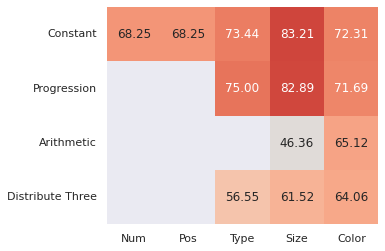

In [65]:
import seaborn as sns
%matplotlib inline
accuracy = accurate_ra_matrix/data_ra_matrix
Mask = np.zeros(np.shape(accuracy))
Mask[accuracy<=0.01] = 1
_accuracy = accuracy*100.0
midpoint = (_accuracy.max() - _accuracy.min()) / 2
# plot the heatmap
# plt.rcParams['font.size'] = 12
plt.rcParams["font.family"] = "Times New Roman"
fig, ax = plt.subplots(1)
sns.heatmap(_accuracy, 
            mask=Mask,
            vmin=0.0, vmax=90.0,
            #center = 45.0,
            cmap="coolwarm",
            square=True,
            robust=True,
            annot=True, fmt=".2f",annot_kws={'size':12},
            cbar=False,
        yticklabels=['Constant', 'Progression', 'Arithmetic', 'Distribute Three'],
        xticklabels=['Num', 'Pos', 'Type', 'Size', 'Color'])
# plt.xlabel('Attributes', fontsize=16)
# plt.ylabel('Rules', fontsize=16)
plt.savefig(f"heatmap_centersingle_i-raven.pdf", bbox_inches='tight', pad_inches=0)
# plt.text(5,12.3, "I-RAVEN", fontsize = 95, color='Black', fontstyle='italic')


In [66]:
# data_path_t = '/common/home/pv217/Downloads/Data-Color/'
test_dt = dataset(data_path, "test", args.img_size, transform=transforms.Compose([ToTensor()]),matrix=True)

# test_dt.file_names = [x for x in test_dt.file_names if '/center_single/' in x]
testloader = DataLoader(test_dt, batch_size=args.batch_size, shuffle=False, num_workers=16)


In [67]:
acc, data_ra_matrix, accurate_ra_matrix = test_ra_pairs()

Total Testing Acc: 46.6538


/tmp/ipykernel_128289/405861729.py:3: RuntimeWarning: invalid value encountered in true_divide
  accuracy = accurate_ra_matrix/data_ra_matrix


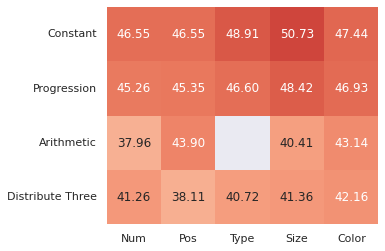

In [68]:
import seaborn as sns
%matplotlib inline
accuracy = accurate_ra_matrix/data_ra_matrix
Mask = np.zeros(np.shape(accuracy))
Mask[accuracy<=0.01] = 1
_accuracy = accuracy*100.0
midpoint = (_accuracy.max() - _accuracy.min()) / 2
# plot the heatmap
# plt.rcParams['font.size'] = 12
plt.rcParams["font.family"] = "Times New Roman"
fig, ax = plt.subplots(1)
sns.heatmap(_accuracy, 
            mask=Mask,
            vmin=0.0, vmax=55.0,
            #center = 45.0,
            cmap="coolwarm",
            square=True,
            robust=True,
            annot=True, fmt=".2f",annot_kws={'size':12},
            cbar=False,
        yticklabels=['Constant', 'Progression', 'Arithmetic', 'Distribute Three'],
        xticklabels=['Num', 'Pos', 'Type', 'Size', 'Color'])
# plt.xlabel('Attributes', fontsize=16)
# plt.ylabel('Rules', fontsize=16)
plt.savefig(f"heatmap_i-raven.pdf", bbox_inches='tight', pad_inches=0)
# plt.text(5,12.3, "I-RAVEN", fontsize = 95, color='Black', fontstyle='italic')


In [ ]:
# Constant, Progression, Arithmetic,
# and Distribute Three


# Scene, Structure, Component,
# Layout, and Entity

In [ ]:
data_path_t = '/common/home/pv217/Downloads/Data-Color/'
valid_dt = dataset(data_path_t, "val", args.img_size,\
                   transform=transforms.Compose([ToTensor()]))
test_dt = dataset(data_path_t, "test", args.img_size, \
                  transform=transforms.Compose([ToTensor()]))
print(len(valid_dt.file_names),len(test_dt.file_names))
validloader = DataLoader(valid_dt, batch_size=args.batch_size, shuffle=False, num_workers=16)
testloader = DataLoader(test_dt, batch_size=args.batch_size, shuffle=False, num_workers=16)
validate()
test()

In [ ]:
data_path_t = '/common/home/pv217/Downloads/Data-Type/'
valid_dt = dataset(data_path_t, "val", args.img_size,\
                   transform=transforms.Compose([ToTensor()]))
test_dt = dataset(data_path_t, "test", args.img_size, \
                  transform=transforms.Compose([ToTensor()]))
validloader = DataLoader(valid_dt, batch_size=args.batch_size, shuffle=False, num_workers=16)
testloader = DataLoader(test_dt, batch_size=args.batch_size, shuffle=False, num_workers=16)
validate()
test()

In [ ]:
data_path_t = '/common/home/pv217/Downloads/Data-Size//'
valid_dt = dataset(data_path_t, "val", args.img_size,\
                   transform=transforms.Compose([ToTensor()]))
test_dt = dataset(data_path_t, "test", args.img_size, \
                  transform=transforms.Compose([ToTensor()]))
validloader = DataLoader(valid_dt, batch_size=args.batch_size, shuffle=False, num_workers=16)
testloader = DataLoader(test_dt, batch_size=args.batch_size, shuffle=False, num_workers=16)
validate()
test()

In [ ]:
data_path_t = '/common/home/pv217/Downloads/Data-Type/'

In [ ]:
config_lst = []
config_val_acc_list = []
config_test_acc_list = []
for i in ['/center_single/','/distribute_four/', '/left_center_single_right_center_single/']:
    valid_dt = dataset(data_path_t, "val", args.img_size, transform=transforms.Compose([ToTensor()]))
    test_dt = dataset(data_path_t, "test", args.img_size, transform=transforms.Compose([ToTensor()]))
    print(i,len(valid_dt.file_names),len(test_dt.file_names))
    valid_dt.file_names = [x for x in valid_dt.file_names if i in x]
    test_dt.file_names = [x for x in test_dt.file_names if i in x]
    validloader = DataLoader(valid_dt, batch_size=args.batch_size, shuffle=False, num_workers=16)
    testloader = DataLoader(test_dt, batch_size=args.batch_size, shuffle=False, num_workers=16)
    config_lst.append(i[1:-1])
    config_val_acc_list.append(validate())
    config_test_acc_list.append(test())
    
    

In [ ]:
data_path_t = '/common/home/pv217/Downloads/Data-Color/'

In [ ]:
config_lst = []
config_val_acc_list = []
config_test_acc_list = []
for i in ['/center_single/','/distribute_four/', '/left_center_single_right_center_single/']:
    valid_dt = dataset(data_path_t, "val", args.img_size, transform=transforms.Compose([ToTensor()]))
    test_dt = dataset(data_path_t, "test", args.img_size, transform=transforms.Compose([ToTensor()]))
    print(i,len(valid_dt.file_names),len(test_dt.file_names))
    valid_dt.file_names = [x for x in valid_dt.file_names if i in x]
    test_dt.file_names = [x for x in test_dt.file_names if i in x]
    validloader = DataLoader(valid_dt, batch_size=args.batch_size, shuffle=False, num_workers=16)
    testloader = DataLoader(test_dt, batch_size=args.batch_size, shuffle=False, num_workers=16)
    config_lst.append(i[1:-1])
    config_val_acc_list.append(validate())
    config_test_acc_list.append(test())
    
    

In [ ]:
data_path_t = '/common/home/pv217/Downloads/Data-Size/'

In [ ]:
config_lst = []
config_val_acc_list = []
config_test_acc_list = []
for i in ['/center_single/','/distribute_four/', '/left_center_single_right_center_single/']:
    valid_dt = dataset(data_path_t, "val", args.img_size, transform=transforms.Compose([ToTensor()]))
    test_dt = dataset(data_path_t, "test", args.img_size, transform=transforms.Compose([ToTensor()]))
    print(i,len(valid_dt.file_names),len(test_dt.file_names))
    valid_dt.file_names = [x for x in valid_dt.file_names if i in x]
    test_dt.file_names = [x for x in test_dt.file_names if i in x]
    validloader = DataLoader(valid_dt, batch_size=args.batch_size, shuffle=False, num_workers=16)
    testloader = DataLoader(test_dt, batch_size=args.batch_size, shuffle=False, num_workers=16)
    config_lst.append(i[1:-1])
    config_val_acc_list.append(validate())
    config_test_acc_list.append(test())
    
    

In [ ]:
import numpy as np

In [ ]:
a = np.load('/common/users/pv217/iraven_data_ext/distribute_four//RAVEN_100_train.npz')
# a = np.load('/common/users/pv217/iraven_data_ext/in_distribute_four_out_center_single//RAVEN_100_train.npz')

In [ ]:
for items in a:
    print(items)

In [ ]:
a["meta_matrix"]
# first four are rules next 5 are attributes
# rule2, attribute2 = 1 (row1)
# rule1, attribute3 = 1 row2
# rule3, attribute4 = 1 row3
# rule2, attribute5 = 1 row4

# create matrix = 4x5; count of all rule attribute pairs; count right anwers and calculate accuracy;



In [ ]:
a["target"]

In [ ]:
a["meta_structure"]

In [ ]:
a["meta_target"]

In [ ]:
a["structure"]

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
for i in range(16):
#     plt.ion()
    plt.figure()
    plt.imshow(a['image'][i])
